<a href="https://colab.research.google.com/github/AcheRaju/DL/blob/main/DLAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets

import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix


In [2]:
(x_train, y_train), (x_test, y_test) = tfds.as_numpy(tfds.load(
    'kmnist',
    split=['train', 'test'],
    batch_size=-1,
    as_supervised=True,
))

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f"Training Set: {x_train.shape}, Validation Set: {x_val.shape}, Test Set: {x_test.shape}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.T4CTU6_3.0.1/kmnist-train.tfrecord*...:   0%|          |…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kmnist/incomplete.T4CTU6_3.0.1/kmnist-test.tfrecord*...:   0%|          | …

Dataset kmnist downloaded and prepared to /root/tensorflow_datasets/kmnist/3.0.1. Subsequent calls will reuse this data.
Training Set: (54000, 28, 28, 1), Validation Set: (6000, 28, 28, 1), Test Set: (10000, 28, 28, 1)


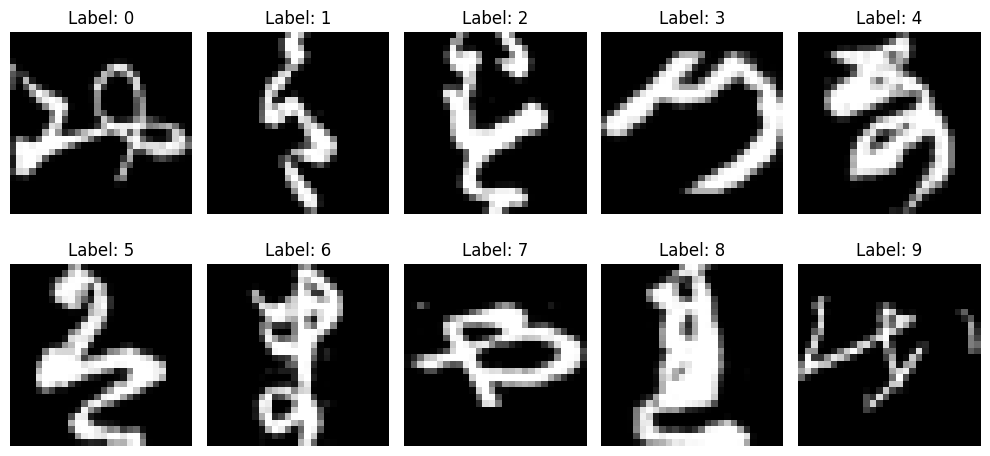

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

for i, ax in enumerate(axes.flat):
    idx = np.where(y_train == i)[0][0]
    ax.imshow(x_train[idx], cmap='gray')
    ax.set_title(f"Label: {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
hyperparameter_combinations = [
    (5, [32, 32, 32], 0.0005, 1e-3, 'adam', 32, 'relu'),
    (10, [64, 64, 64, 64], 0, 1e-4, 'sgd', 16, 'sigmoid'),
    (5, [128, 128, 128, 128, 128], 0.5, 1e-3, 'rmsprop', 64, 'relu'),
    (10, [32, 32, 32], 0.0005, 1e-4, 'nadam', 32, 'sigmoid'),
    (5, [64, 64, 64, 64], 0, 1e-3, 'nesterov', 16, 'relu'),
    (10, [128, 128, 128, 128, 128], 0.5, 1e-4, 'momentum', 64, 'sigmoid'),
    (5, [32, 32, 32], 0.0005, 1e-3, 'sgd', 32, 'relu'),
    (10, [64, 64, 64, 64], 0, 1e-4, 'adam', 16, 'sigmoid')
]
def create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units=units, activation=activation, kernel_regularizer=l2(weight_decay)))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    if optimizer in ['momentum', 'nesterov']:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=(optimizer == 'nesterov'))
    else:
        optimizer = tf.keras.optimizers.get({'class_name': optimizer, 'config': {'learning_rate': learning_rate}})

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
import pandas as pd

results = []

for i, params in enumerate(hyperparameter_combinations):
    (num_epochs, hidden_layers, weight_decay, learning_rate,
     optimizer, batch_size, activation) = params

    print(f"\nTraining Model {i+1} with: {params}")

    try:
        model = create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate)
        history = model.fit(x_train, y_train,
                            epochs=num_epochs, batch_size=batch_size,
                            validation_data=(x_val, y_val), verbose=1)

        val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

        results.append({
            'Model': i + 1,
            'Epochs': num_epochs,
            'Layers': hidden_layers,
            'Weight Decay': weight_decay,
            'Learning Rate': learning_rate,
            'Optimizer': optimizer,
            'Batch Size': batch_size,
            'Activation': activation,
            'Validation Accuracy': val_acc,
            'Test Accuracy': test_acc
        })

    except Exception as e:
        print(f"Error training model {i+1}: {e}")

df_results = pd.DataFrame(results)

print("\nTraining Summary:")
display(df_results)



Training Model 1 with: (5, [32, 32, 32], 0.0005, 0.001, 'adam', 32, 'relu')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7209 - loss: 0.9427 - val_accuracy: 0.8925 - val_loss: 0.4333
Epoch 2/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8936 - loss: 0.4307 - val_accuracy: 0.9077 - val_loss: 0.3801
Epoch 3/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9174 - loss: 0.3652 - val_accuracy: 0.9140 - val_loss: 0.3623
Epoch 4/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9261 - loss: 0.3352 - val_accuracy: 0.9168 - val_loss: 0.3663
Epoch 5/5
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9344 - loss: 0.3105 - val_accuracy: 0.9233 - val_loss: 0.3408

Training Model 2 with: (10, [64, 64, 64, 64], 0, 0.0001, 'sgd', 16, 'sigmoid')
Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.0972 - loss: 2.3897 - val_accuracy: 0.1018 - val_loss: 2.3373
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.0991 - loss: 2.3278 - val_accuracy: 0.1018 - val_loss: 2.3134
Epoch 3/10
3

,Model,Epochs,Layers,Weight Decay,Learning Rate,Optimizer,Batch Size,Activation,Validation Accuracy,Test Accuracy
0,1,5,"[32, 32, 32]",0.0005,0.0010,adam,32,relu,0.923333,0.8413
1,2,10,"[64, 64, 64, 64]",0.0000,0.0001,sgd,16,sigmoid,0.113167,0.1018
2,3,5,"[128, 128, 128, 128, 128]",0.5000,0.0010,rmsprop,64,relu,0.096667,0.1000
3,4,10,"[32, 32, 32]",0.0005,0.0001,nadam,32,sigmoid,0.772000,0.6337
4,5,5,"[64, 64, 64, 64]",0.0000,0.0010,nesterov,16,relu,0.929333,0.8513
5,6,10,"[128, 128, 128, 128, 128]",0.5000,0.0001,momentum,64,sigmoid,0.096333,0.1000
6,7,5,"[32, 32, 32]",0.0005,0.0010,sgd,32,relu,0.717833,0.5656
7,8,10,"[64, 64, 64, 64]",0.0000,0.0001,adam,16,sigmoid,0.877167,0.7645


In [12]:
best_model_config = df_results.loc[df_results['Validation Accuracy'].idxmax()].to_dict()

print(f"\nBest Model Configuration: {best_model_config}")

num_epochs = best_model_config['Epochs']
hidden_layers = best_model_config['Layers']
weight_decay = best_model_config['Weight Decay']
learning_rate = best_model_config['Learning Rate']
optimizer = best_model_config['Optimizer']
batch_size = best_model_config['Batch Size']
activation = best_model_config['Activation']

best_model = create_model(hidden_layers, activation, optimizer, weight_decay, learning_rate)

x_combined = np.concatenate((x_train, x_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

best_model.fit(x_combined, y_combined, epochs=num_epochs, batch_size=batch_size, verbose=1)

test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")



Best Model Configuration: {'Model': 5, 'Epochs': 5, 'Layers': [64, 64, 64, 64], 'Weight Decay': 0.0, 'Learning Rate': 0.001, 'Optimizer': 'nesterov', 'Batch Size': 16, 'Activation': 'relu', 'Validation Accuracy': 0.9293333292007446, 'Test Accuracy': 0.8513000011444092}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.5924 - loss: 1.2476
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8796 - loss: 0.3979
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9121 - loss: 0.2923
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9290 - loss: 0.2337
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9393 - loss: 0.1990

Final Test Accuracy: 0.8390


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8404 - loss: 0.5411
Test Accuracy with Cross-Entropy Loss: 0.8390
Test Loss with Cross-Entropy: 0.5433
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


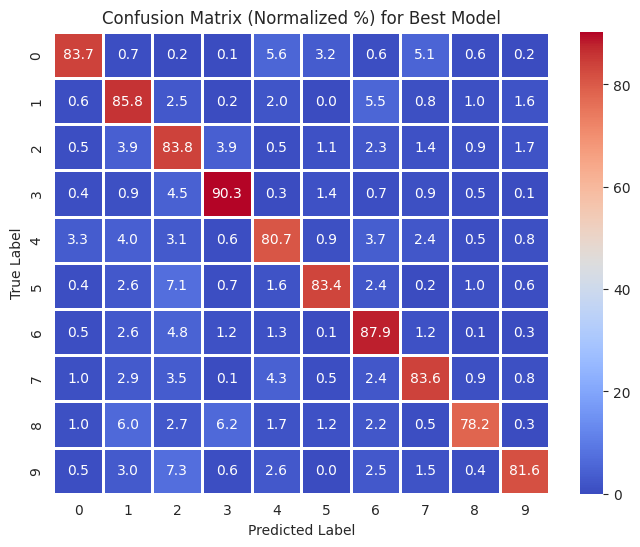

In [13]:
test_loss_ce, test_acc_ce = best_model.evaluate(x_test, y_test, verbose=1)
print(f'Test Accuracy with Cross-Entropy Loss: {test_acc_ce:.4f}')
print(f'Test Loss with Cross-Entropy: {test_loss_ce:.4f}')

y_pred = np.argmax(best_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")

ax = sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="coolwarm", linewidths=1,
                 xticklabels=range(10), yticklabels=range(10), cbar=True)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Normalized %) for Best Model')
plt.show()

In [14]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_combined_onehot = np.concatenate((y_train_onehot, y_val_onehot), axis=0)

model_config = {
    "hidden_layers": hidden_layers,
    "activation": activation,
    "optimizer": "sgd",
    "weight_decay": weight_decay,
    "learning_rate": learning_rate
}

best_model_mse = create_model(**model_config)
best_model_mse.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
    loss="mean_squared_error",
    metrics=["accuracy"]
)

x_combined = np.concatenate((x_train, x_val), axis=0)
best_model_mse.fit(x_combined, y_combined_onehot, epochs=num_epochs, batch_size=batch_size, verbose=1)

test_loss_mse, test_acc_mse = best_model_mse.evaluate(
    x_test, tf.keras.utils.to_categorical(y_test, num_classes=10), verbose=1
)

print(f"\nTest Accuracy with Squared Error Loss: {test_acc_mse:.4f}")
print(f"Test Loss with Squared Error: {test_loss_mse:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.1155 - loss: 0.0900
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.2316 - loss: 0.0874
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.3282 - loss: 0.0802
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.5499 - loss: 0.0641
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.6436 - loss: 0.0503
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5295 - loss: 0.0621

Test Accuracy with Squared Error Loss: 0.5312
Test Loss with Squared Error: 0.0621
